In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from model.resunet import ResUNet
import torch.nn.functional as F
import cv2
from pytorch_model_summary import summary
import math
import os

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [11]:
def imshow(img):
    '''
    input: tensor [1, h, w]
    '''
    d_img = (img[0] + 1.0) / 2.0
    plt.figure(figsize=(5,5))   
    plt.imshow(d_img, cmap='gray')
    plt.axis('off')
    plt.show()

In [12]:
batch_size = 256
rsl = 32 

In [13]:
transform = transforms.Compose([transforms.Resize((rsl, rsl)),
                                transforms.ToTensor(),
                                transforms.Lambda(lambda x: (x*2) -1)])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

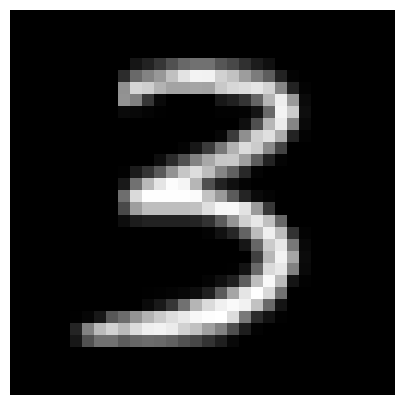

In [14]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
image = images[0]

imshow(image)

Sobel Filter Simulation

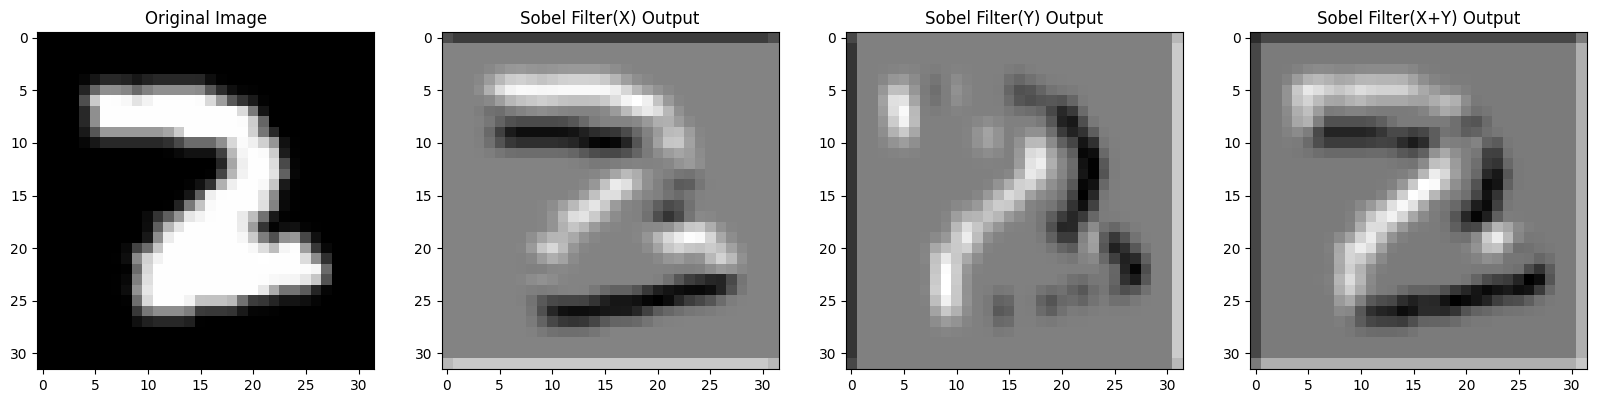

In [27]:
# Define Sobel filter
sobel_filter_x = nn.Conv2d(1, 1, kernel_size=3, padding=1, bias=False)
sobel_filter_x.weight.data = torch.FloatTensor([[[[-1, -2, -1],
                                                  [0, 0, 0],
                                                  [1, 2, 1]]]])

sobel_fiter_y = nn.Conv2d(1, 1, kernel_size=3, padding=1, bias=False)
sobel_fiter_y.weight.data = torch.FloatTensor([[[[-1, 0, 1], 
                                                [-2, 0, 2],
                                                [-1, 0, 1]]]])

# Apply Sobel filter
with torch.no_grad():
    sobel_output_x = sobel_filter_x(image)
    sobel_output_y = sobel_fiter_y(image)
    sobel_output = sobel_output_x + sobel_output_y

org = image[0].numpy()
show_x = sobel_output_x[0].numpy()
show_y = sobel_output_y[0].numpy()
show = sobel_output[0].numpy()

# Plot the original and Sobel-filtered images
plt.figure(figsize=(20, 10))
plt.subplot(1, 4, 1)
plt.imshow(org, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 4, 2)
plt.imshow(show_x, cmap='gray')
plt.title('Sobel Filter(X) Output')

plt.subplot(1, 4, 3)
plt.imshow(show_y, cmap='gray')
plt.title('Sobel Filter(Y) Output')

plt.subplot(1, 4, 4)
plt.imshow(show, cmap='gray')
plt.title('Sobel Filter(X+Y) Output')

plt.show()

Make Test Condition

In [34]:
def sobelFilter(img, device):
    '''
    input: tensor [1, h, w]
    '''
    sobel_filter_x = nn.Conv2d(1, 1, kernel_size=3, padding=1, bias=False)
    sobel_filter_x.weight.data = torch.FloatTensor([[[[-1, -2, -1],
                                                    [0, 0, 0],
                                                    [1, 2, 1]]]]).to(device)

    sobel_fiter_y = nn.Conv2d(1, 1, kernel_size=3, padding=1, bias=False)
    sobel_fiter_y.weight.data = torch.FloatTensor([[[[-1, 0, 1], 
                                                    [-2, 0, 2],
                                                    [-1, 0, 1]]]]).to(device)
    
    return (sobel_filter_x(img) + sobel_fiter_y(img)).to(device)

In [35]:
width_num = 10
height_num = 10
total_num = width_num * height_num
condition = torch.zeros(total_num, 32, 32, 1).to(device)

In [52]:
# make condition (randomly)
test_dataiter = iter(test_loader)
test_images, test_labels = next(test_dataiter)
sobel_outputs = sobelFilter(test_images.to(device), device)

t = torch.randint(0, batch_size, size=(1,), device=device).long()
condition = sobel_outputs[t : t+total_num] # [100, 32, 32, 1]

Show Condition Images

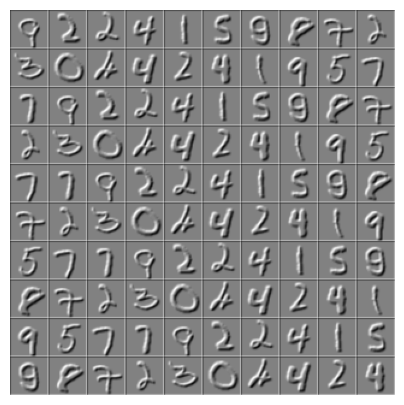

In [53]:
np_cond = condition.permute(0,2,3,1).cpu().detach().numpy()
out_img = np.zeros((32*height_num,32*width_num,1)) # [320, 320, 1]

# reshape numpy images
rs_img = np.resize(np_cond, (height_num, width_num, rsl, rsl)) # [10, 10, 32, 32]

# make numpy images to grid image
for i in range(height_num):
    for j in range(width_num):
        out_img[i * rsl:i * rsl +rsl, j * rsl:j * rsl +rsl, 0] = rs_img[i, j, :, :]

imshow(torch.from_numpy(out_img).permute(2,0,1))